#  프로젝트: 뉴스기사 요약해보기

---

## Prestep. Model Import
---

In [ ]:
!pip install summa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 54 kB 2.2 MB/s 
  Created wheel for summa: filename=summa-1.2.0-py3-none-any.whl size=54412 sha256=5b19554296eec7466cbb4c2b5afad63d58b341bf396874e661fe9ad44b8f02e2
  Stored in directory: /root/.cache/pip/wheels/29/64/ac/7b443477588d365ef37ada30d456bdf5f07dc5be9f6324cb6e
Successfully built summa


In [ ]:
!pip install pyyaml h5py 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os

import pandas as pd
import urllib.request
from nltk.corpus import stopwords #불용어 처리 라이브러리
from bs4 import BeautifulSoup
import re

import multiprocessing as mp   # 멀티 프로세싱으로 전처리 속도를 획기적으로 줄여봅시다
from multiprocessing import Pool
import numpy as np
import time
from functools import partial  # map을 할 때 함수에 여러 인자를 넣어줄 수 있도록 합니다
import matplotlib.pyplot as plt

from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import requests
from summa.summarizer import summarize

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Step 1. 데이터 수집하기

---

In [ ]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [ ]:
data.sample(10)

,headlines,text
40843,Steve Smith to not appeal his 12-month ban fro...,Former Australian captain Steve Smith has conf...
48316,"AI, Vistara flights come within 100ft, avoid c...",A mid-air collision between an Air India aircr...
72243,Trump's attacks on media have concrete aims: U...,US President Donald Trump's attacks against me...
93732,Study finds first ever evidence of rescue beha...,Researchers have found the first evidence of r...
52689,The greatest wall is the one and only Rahul Dr...,"Wishing Rahul Dravid on his 45th birthday, Sac..."
51368,Firecracker unit owner arrested in Bawana fire...,The Delhi Police on Sunday arrested Manoj Jain...
24948,War with Iran would be mother of all wars: Rou...,"Warning the US against provoking Iran, Preside..."
8849,Nepotism exists but there are stars who're not...,"Preity Zinta, while talking about nepotism, sa..."
97417,Jharkhand village names streets after most edu...,"Juri, a village in Jharkhand's East Singhbhum ..."
49892,Firm that helps make VR content without coding...,Bengaluru-headquartered virtual reality (VR) s...


10개를 출력해보니 기사제목과 기사 내용 2개로 나눠져 있습니다.

뉴스의 제목이 곧 요약이니 이를 기준삼아 학습시키면 될 거같습니다.

## Step 2. 데이터 전처리하기 (추상적 요약)

---

### 중복값과 결측치 제거

In [ ]:
len(data)

98401

### 결측치 확인

In [ ]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


결측치가 없음을 확인했습니다.

In [ ]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('Headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
\
Headline 열에서 중복을 배제한 유일한 샘플의 수 : 98280

Headline의 중복을 처리해야 할지 말아야 할지 고민이다. 

### Headline 에서 중복된 위치 찾기

In [ ]:
# headline에서 중복된 위치 찾기
duplicated_headlines = data.duplicated(subset=['headlines'], keep=False)
duplicated_location = data.loc[duplicated_headlines,'headlines' ]
print(duplicated_location)

23       Isha Ambani features on February cover of Vogu...
24       Indian Oil looking for annual deal to buy crud...
25       Pacer once took 7 wickets for just 1 run in 32...
416      Mughal Gardens to open for public from February 6
1017     Longest Test innings was longer than 10 footba...
                               ...                        
95135    Parveen Babi was 1st Indian film star on TIME ...
95473    Sachin had not let Sehwag watch 2011 World Cup...
95670    How did the tradition of April Fools' Day orig...
96540    Sachin first opened in ODIs due to Sidhu's 'st...
97489              Who are the richest women in the world?
Name: headlines, Length: 235, dtype: object


중복된 위치를 찾아봐도 뭐가 중복되었는지 알 수 없다. 


In [ ]:
duplicated_location.to_frame()

,headlines
23,Isha Ambani features on February cover of Vogu...
24,Indian Oil looking for annual deal to buy crud...
25,Pacer once took 7 wickets for just 1 run in 32...
416,Mughal Gardens to open for public from February 6
1017,Longest Test innings was longer than 10 footba...
...,...
95135,Parveen Babi was 1st Indian film star on TIME ...
95473,Sachin had not let Sehwag watch 2011 World Cup...
95670,How did the tradition of April Fools' Day orig...
96540,Sachin first opened in ODIs due to Sidhu's 'st...


일단은 중복되는 Text만 제거

In [ ]:
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


## 텍스트 정규화와 불용어 제거

In [ ]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


불용어 사전 개수

In [ ]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

### 전처리 함수

In [ ]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [ ]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_headlines = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("summary:", preprocess_sentence(temp_headlines, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
summary: great way to start the day


### 훈련 데이터 전체에 대해서 전처리를 수행

Text 에 대해 전처리

In [ ]:
clean_text = []
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

Headlines 에 대해 전처리

In [ ]:
clean_headlines = []
# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


전처리 후 결측치가 발생했는지 확인

In [ ]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [ ]:
data.isnull().sum()

headlines         0
text              0
decoder_input     0
decoder_target    0
dtype: int64

In [ ]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


전처리한 데이터 저장.

In [ ]:
import pickle

path = "/content/drive/MyDrive/Data/002NLP/review/data"

In [ ]:
# wb 

# ## Save pickle
# with open(path + "/clean_text.pickle","wb") as ct:
#     pickle.dump(clean_text, ct)

# with open(path + "/clean_summary.pickle","wb") as cs:
#     pickle.dump(clean_summary, cs)

전처리한 데이터 불러오기

불러오기 전 원본 데이터 불러오기

In [ ]:
## Load pickle
with open(path + "/clean_text.pickle","rb") as ct:
    clean_text = pickle.load(ct)

with open(path + "/clean_summary.pickle","rb") as cs:
    clean_summary = pickle.load(cs)

## 텍스트 길이 분포 출력

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
제목의 최소 길이 : 1
제목의 최대 길이 : 16
제목의 평균 길이 : 9.299532330215534


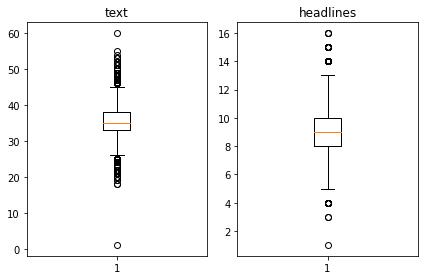

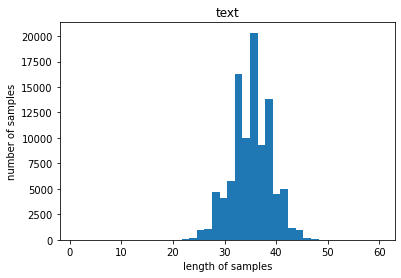

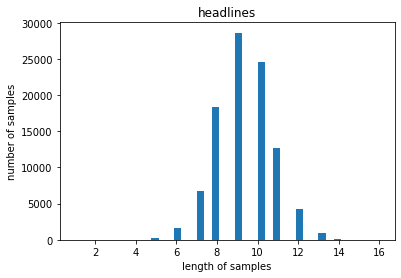

In [ ]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('제목의 최소 길이 : {}'.format(np.min(headlines_len)))
print('제목의 최대 길이 : {}'.format(np.max(headlines_len)))
print('제목의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
text_max_len = 50
headlines_max_len = 10

## 시작 토큰과 종료 토큰 추가하기

###  훈련 데이터와 테스트 데이터를 분리

In [ ]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",sostoken upGrad learner switches to career in ...,upGrad learner switches to career in ML & Al w...
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...,sostoken Delhi techie wins free food from Swig...,Delhi techie wins free food from Swiggy for on...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...,sostoken New Zealand end Rohit Sharma-led Indi...,New Zealand end Rohit Sharma-led India's 12-ma...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer...",sostoken Aegon life iTerm insurance plan helps...,Aegon life iTerm insurance plan helps customer...
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...,"sostoken Have known Hirani for yrs, what if Me...","Have known Hirani for yrs, what if MeToo claim..."


인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장

In [ ]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

### 훈련 데이터와 테스트 데이터를 분리

```encoder_input```과 크기와 형태가 같은 랜덤한 정수 시퀀스 생성

In [ ]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[ 4966 40443 65638 ... 86307 43001 76955]


이 정수 시퀀스를 이용해 데이터 샘플 순서를 재정의

In [ ]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

훈련 데이터와 테스트 데이터  8:2의 비율로 분리한다.

In [ ]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19680


In [ ]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78721
훈련 레이블의 개수 : 78721
테스트 데이터의 개수 : 19680
테스트 레이블의 개수 : 19680


## 정수 인코딩

### 단어 집합(vocabulary) 만들기 및 정수 인코딩

훈련데이터로 단어 집합 생성하기

In [ ]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

훈련데이터로 단어집합을 생성하였다.

단어 집합은 ```src_tokenizer.word_index```에 저장됨.
빈도수가 낮은 단어들은 허수로 생각하고 훈련 데이터에서 제외하고 진행

등장 빈도수가 7회 미만인 단어들의 비중을 차지하는지 확인

```src_tokenizer.word_counts.items()```를 통해서 통계적인 정보를 얻을 수 있음.

## 패딩하기

In [ ]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 91111
등장 빈도가 6번 이하인 희귀 단어의 수: 66325
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 24786
단어 집합에서 희귀 단어의 비율: 72.79582048270791
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.7235829185608114


등장 빈도가 threshold 값인 7회 미만, 즉 6회 이하인 단어들은 단어 집합에서 약 70%를 차지하지만 실제 훈련 데이터 등장 비율은 3.48%밖에 안되므로 허수라 생각할 수 있다.

등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거

따라서 이를 제외한 단어 집합의 크기를 22100으로 제한

num_words로 단어 집합의 크기를 제한

In [ ]:
src_vocab = 22100
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 22100으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [ ]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[1, 2607, 240, 4028, 21488, 4842, 1981, 4, 1, 5, 6577, 4, 3582, 8, 1085, 9, 2353, 2863, 2924, 21, 9031, 368, 32, 9, 245, 210, 184, 129, 44, 69, 36, 54, 106, 5, 2451, 10864, 6073, 4, 1, 4842, 11, 20273, 36, 24, 621, 5, 276, 9032, 1, 4842, 12, 11327, 454, 20, 13646, 8616], [955, 3, 1190, 4, 256, 683, 13232, 73, 58, 6513, 1927, 12507, 356, 51, 11, 14, 23, 17533, 94, 16, 87, 56, 1799, 6791, 1546, 15, 109, 1102, 14, 63, 10, 11, 1, 2893, 23, 25, 15053, 113, 18, 56, 7047, 17, 4802, 12507, 12, 92, 496, 9, 523, 11, 15606, 6, 7047, 1, 190, 788, 5, 1906], [3, 1367, 2623, 318, 2981, 8, 593, 17, 6315, 104, 22, 852, 6, 115, 24, 317, 735, 4350, 723, 199, 14, 6177, 51, 2, 3141, 6122, 11, 14, 82, 1169, 89, 1180, 1, 723, 128, 1335, 51, 2, 1315, 9, 6122, 36, 3, 154, 1161, 847, 1, 1293, 16, 1, 190, 1620, 13, 1236, 15, 61]]


headlines에 대해서도 동일한 작업을 수행. 

```decoder_input_train```을 입력으로 전체 단어 집합과 각 단어에 대한 빈도수를 계산한다.

In [ ]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [ ]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 40807
등장 빈도가 5번 이하인 희귀 단어의 수: 29509
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 11298
단어 집합에서 희귀 단어의 비율: 72.31357365157939
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.151271164044469


등장 빈도가 5회 이하인 단어들은 단어 집합에서 약 65%를 차지하고 있음. 

아까와 마찬가지로 실제로 훈련 데이터에서 등장 비율은 4.65%밖에 되지 않는다.

19700 을 단어 집합의 크기로 제한

In [ ]:
tar_vocab = 19700
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 4472, 391, 17586, 5923, 867, 5, 1589, 4, 537], [1, 5291, 72, 81, 163, 889, 704, 7689, 86], [1, 19, 140, 68, 335, 3, 2637, 5708, 142, 89, 424, 5, 12698], [1, 875, 1225, 146, 1307, 648, 37, 392, 1384], [1, 153, 99, 506, 4922, 48, 340, 5, 357, 8, 12, 62, 174]]
target
decoder  [[4472, 391, 17586, 5923, 867, 5, 1589, 4, 537, 2], [5291, 72, 81, 163, 889, 704, 7689, 86, 2], [19, 140, 68, 335, 3, 2637, 5708, 142, 89, 424, 5, 12698, 2], [875, 1225, 146, 1307, 648, 37, 392, 1384, 2], [153, 99, 506, 4922, 48, 340, 5, 357, 8, 12, 62, 174, 2]]


In [ ]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78721
훈련 레이블의 개수 : 78721
테스트 데이터의 개수 : 19680
테스트 레이블의 개수 : 19680


In [ ]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

## Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)

---

### 인코더 설계

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
# encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
# encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

### 디코더 설계

In [ ]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

### 디코더의 출력층을 설계

In [ ]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 50, 128)      2828800     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 50, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

1200만개의 파라미터는 너무 많은것 같습니다.

## 어텐션 메커니즘

In [ ]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 50, 128)      2828800     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 50, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                            

이제는 파라미터의 개수가 1730만에 육박한다. 학습이 오래 걸릴것으로 예상된다.

## 모델 테스트

### 가중치 저장 및 early stop 콜백 설정

In [ ]:
checkpoint_path = "/content/drive/MyDrive/weight_callback/ex07/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# 모델의 가중치를 저장하는 콜백 만들기
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# 옵티마이저의 상태를 저장하는 것과 관련되어 경고가 발생할 수 있습니다.
# 이 경고는 (그리고 이 노트북의 다른 비슷한 경고는) 이전 사용 방식을 권장하지 않기 위함이며 무시해도 좋습니다.

In [ ]:
# early stop 조건을 설정.
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

tensorflow에서의 callbacks 함수를 사용해 다양한 옵션을 사용할 수 있는데 그 중 checkpoint를 사용하여 학습한 모델의 가중치를 불러 오거나, earlystop을 설정 할 수 있다.



In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es,cp_callback], epochs=50)

Epoch 1/50
308/308 [==============================] - ETA: 0s - loss: 6.8976
Epoch 1: saving model to /content/drive/MyDrive/weight_callback/ex07/cp.ckpt
308/308 [==============================] - 224s 689ms/step - loss: 6.8976 - val_loss: 6.4498
Epoch 2/50
308/308 [==============================] - ETA: 0s - loss: 6.3801
Epoch 2: saving model to /content/drive/MyDrive/weight_callback/ex07/cp.ckpt
308/308 [==============================] - 215s 698ms/step - loss: 6.3801 - val_loss: 6.1022
Epoch 3/50
308/308 [==============================] - ETA: 0s - loss: 6.0102
Epoch 3: saving model to /content/drive/MyDrive/weight_callback/ex07/cp.ckpt
308/308 [==============================] - 212s 689ms/step - loss: 6.0102 - val_loss: 5.8276
Epoch 4/50
308/308 [==============================] - ETA: 0s - loss: 5.7151
Epoch 4: saving model to /content/drive/MyDrive/weight_callback/ex07/cp.ckpt
308/308 [==============================] - 211s 686ms/step - loss: 5.7151 - val_loss: 5.5935
Epoch 5/50
3

### 학습된 가중치 로드

In [ ]:
#model.load_weights(checkpoint_path)

### Loss Visualization

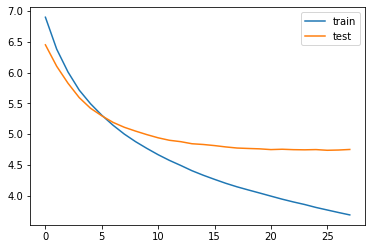

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

train데이터의loss는 꾸준히 감소하는 반면, test data(val data)의 loss는 4.7에서 수렴하는 경향을 보였다.

## 인퍼런스 모델 구현하기

In [ ]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [ ]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])


### 어텐션 메커니즘을 사용하는 출력층을 설계

In [ ]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

### 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수

In [ ]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## 모델 테스트

In [ ]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

## Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)

---

25개의 문장을 비교해보았다.

In [ ]:
for i in range(25):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : intentionally cropped photos of president donald trump's inauguration to remove empty space and make the audience look larger trump claimed footage of the event did not match with the number of people he saw from the stage white house had claimed trump's inauguration had attracted the largest ever inauguration audience 
실제 요약 : photographer admits he edited trump's inauguration pics report 
예측 요약 :  trump slams trump for calling him


원문 : hyderabad for allegedly making false promises to the nris of exchanging the old demonetised notes an official said demonetised currency notes of ã¢ââ¹500 and ã¢ââ¹1 000 totalling up to ã¢ââ¹1 85 crore were seized from the accused along with this the cops also seized two cars and 13 mobile phones 
실제 요약 : hyderabad 13 held for promising nris to exchange old notes 
예측 요약 :  delhi govt issues ã¢ââ¹5 crore for cash notes


원문 : fraud got into an argument with the police on a facebook post appealing for communities across the uk to look out for h

뭔가 잘 안됨

## Step 5. Summa을 이용해서 추출적 요약해보기

---

출처 :

https://github.com/hyyoo3526/AIFFEL_EXPLORATION/blob/main/EXPLORATION_10/EXPLORATION_IC1_10_news_summarization.ipynb



text (str) : 요약할 테스트.

ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값

words (int or None, optional) – 출력에 포함할 단어 수.

만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.
split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환

In [ ]:
print('Summary:')
for i in range(10):
    print("원문 :", data['text'][i])
    print("실제 요약 :", data['headlines'][i])
    print("추출적 요약 :", summarize(data["text"][i], ratio=0.5))
    print("\n")

Summary:
원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike
추출적 요약 : upGrad's Online Power Learning has powered 3 lakh+ careers.


원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
실제 요약 : Delhi techie wins free food from Swiggy for one year on CRED
추출적 요약 : Users get one CRED coin per rupee 

전반적으로 요약이 잘 된것 같은 문장도 있지만 문장의 길이가 긴 문장은 여지없이 텍스트 내용을 그대로 가져왔다.

In [ ]:
print('Summary:')
for i in range(10):
    print("원문 :", data['text'][i])
    print("실제 요약 :", data['headlines'][i])
    print("추출적 요약 :", summarize(data["text"][i], ratio=0.5, split=True))
    print("\n")

Summary:
원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike
추출적 요약 : ["upGrad's Online Power Learning has powered 3 lakh+ careers."]


원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
실제 요약 : Delhi techie wins free food from Swiggy for one year on CRED
추출적 요약 : ['Users get one CRED coin per 

위와 마찬가지이다.

In [79]:
print('Summary:')
for i in range(10):
    print("원문 :", data['text'][i])
    print("실제 요약 :", data['headlines'][i])
    print("추출적 요약 :", summarize(data["text"][i], words=15))
    print("\n")

Summary:
원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike
추출적 요약 : upGrad's Online Power Learning has powered 3 lakh+ careers.


원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
실제 요약 : Delhi techie wins free food from Swiggy for one year on CRED
추출적 요약 : Users get one CRED coin per rupee 

이번에는 아예 요약을 하지 못한 경우도 있었다. 추출적 요약은 생각보다 성능이 좋지 않다.

## 회고

이번 노드에서 배운점은 자연어를 처리할 때 어떤 프로세스로 진행이 되는지,
어떻게 RNN 모델을 사용하는지 어떻게 layer를 쌓게 되는지 조금은 알 거 같다.

그 외에 데이터의 용량이 260MB정도밖에 안되었지만, 이 데이터들을 전처리할 때도 시간이 많이 들었고, 모델에 학습시키는데에도 시간이 꽤 많이 들었다. 따라서 모델을 이해하지 못한 채로 하이퍼 파라미터등을 변경하기엔 시간이 빡빡하여 진행하지는 않았다.

이번에 진행했던 추상적 요약에서 약 25개 정도의 문장을 요약해 낸 결과, 문법에 맞지 않는 문장, 내용을 짐작 할 수 없는 문장, 쓸데없이 단어가 반복되어 완성도가 떨어지는 문장들이 있었다.

또한 원문 text에서 손상된 텍스트 파일이 발견된 점, 제거되지 않은 특수문자가 있었다는 점에서 많이 아쉬웠다. 만약 전처리 과정에서 이들을 걸러냈더라면 조금 더 나은 결과를 얻을 수 있었을 것으로 예상할 수 있기에 더 아쉽다.